# Quick prototyping with fastai2 (Car classifier example)

## What we will do ?
We will build a simple car classfier, you basicly give it an image of a car (interior or exterior) and the model will 'guess' what brand it is and if it is the interior or exterior of it. Okay, let's do this.

## Before we start
I will not go into every detail of the code, so prior knowledge of python is required. Also make sure that you are using a GPU (for colab just click Runtime -> Change runtime type -> GPU). That said we will first start by importing the tools that we will need to do the job.

In [1]:
!pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 727kB 8.8MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 1.0MB 24.5MB/s 
     |████████████████████████████████| 194kB 57.2MB/s 
     |████████████████████████████████| 40kB 6.3MB/s 
     |████████████████████████████████| 92kB 12.3MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 2.6MB 58.3MB/s 


## 1. Get the data
To train a model, we will need data that it uses to learn from (it's like a student learning from a book, where the student is the model and the book is the data). For that we will download our car images using the Bing Api Key, to get one i will refer to this great post by Ivoline Ngong on the fastai forums: [Get bing api key](https://forums.fast.ai/t/getting-the-bing-image-search-key/67417). Okay, now that we got our key we will use it to download the images in this case, we will download Audi/ BMW/ Mercedes (interior/exterior) images and put them in different folders accroding to their category (we will call 'categories' labels from now on, this is the jargon used in deep learning) 

In [2]:
key = 'd4a51bcea8bd4a94b7d2d467b8b5d987'
path = Path('/content/images')
brands = ['bmw', 'mercedes', 'audi']
perspective = ['interior', 'exterior']
result = itertools.product(brands, perspective)
if not path.exists():
  path.mkdir()
  for b, p in result: 
    dest = Path(path/f'{b}_{p}')
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{b} {p}')
    download_images(dest, urls=results.attrgot('content_url'))

We then check if there are any corrupted files in the mix, we use *verify_images* for that (which is provided by fastai), and we obviously unlink (delete) them, so we don't encounter errors further down the road.  

You can notice that we use an intresting method which is provided by fastai, *get_images_files*, which is used as the name suggests to search for images (with different extensions) in a given path (input), this is done **recursively** by default (searches in all sub-directories of the path given) and returns a list of paths of those images.

In [3]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

## 2. Clean the data
Now comes the " *NO, GOD PLEASE NO* " moment, but will try to make it a bit more "*fun*".

The intuitive approach will be to do data cleaning before we train our model, but what we will do instead is train a quick and simple model to help us clean the data.

> Don't worry about the code for, we'll explain how train a model later.

In [4]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(244))
dls = db.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


If we plot our *top losses* (the images for which the model got the wrong guess), we see that he was not that wrong after all. I mean, taking the first image it looks like a bmw exterior to me.

Well this is due to downloading images from bing, when you do a search for images (in any search engine) you will get the desired images that you searched for but sometimes, you'll get some " *undesired* " ones as well.

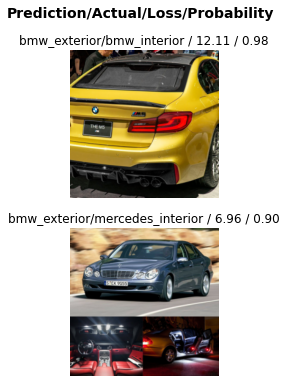

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(2, nrows=2)

So what do we do now ? Good question, we will use a tool provided by fastai to clean our data, which is called **ImageClassifierCleaner**. And it provides us with a nice GUI interface that we can interact with to delete/ keep (by default) /or modify the label of the images in the dataset.
> The **ImageClassifierCleaner** does not allow us to delete or modify the labels directly but rather gives a list of the paths of the different images that we selected. 

> You will have to iterate this process untill you have cleaned your dataset (e.g. Re-train -> plot top losses -> clean)

In [6]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In this example, we will change the labels (category) from bmw interior to bmw exterior.

In [8]:
for idx,cat in cleaner.change():
  cleaner.fns[idx].rename(path/cat/f'(1){cleaner.fns[idx].name}')

## 3. Training
Before training our model we will need to turn our downloaded data into a DataLoaders object (which is just an object containing our train and validation set, e.g. the images used for training and the images used to test how well our model performs), we need to tell fastai at least four things:

- What kinds of data we are working with:  
  *blocks=(ImageBlock, CategoryBlock)*, we are dealing with images and we want categories as the output. 
-  How to get the list of items  
 *get_items=get_image_files* (remember this the method we described earlier)
- How to label these items .   
 *get_y=parent_label*, this means we label them according to the folder they're in.
- How to create the validation set  
 *splitter=RandomSplitter(valid_pct=0.1, seed=42)*, we take 10% of our images and use them to test how good our model performs, and set the seed so we always have the same split.

We also are going to be using a technique called **Data Augmentation**, which is just a set of standard transformations applied to our images (rotation, contrast, brightness, ..., all are contained in the *aug_transforms* method), this is usually done to increase the size of our dataset, when you have a small one (not a lot of images) like our case.  

*item_tfms=RandomResizedCrop(244, min_scale=0.5), batch_tfms=aug_transforms()*

Now the difference between *item_tfms* and *batch_tfms*, is just that one is applied one item at a time, the other is applied to a batch of images at a time (this is where the GPU comes in handy, beacause it can do multiple tasks in parallel, the CPU does this sequencially).

> Note that we also resize all of our images into 244x244 format, so all our images are of the same size (but you can choose any size you want).

In [9]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(244))
dls = db.dataloaders(path)

Now, to train our model we will use a technique called **transfor learning**, which basicly means to use an already pre-trained model (which was trained for some task) for a different task that we are intrested in (classifiying cars).

We will call the method *cnn_learner* for this purpose, we put our *Dataloaders object* as the first parameter, the architecture as the second (which is the "*mathematical template of our function*" in this case *Resnet*, 34 just means the number of layers), and last argument is the **metric**, which the thing that we use as humans to evaluate how good the model performs (in this case *error_rate*, which is the ratio of number of misclassified images / total number of images).

Finally, we use the method *fine_tune*, which will do two things :  
- Do one epoch (one pass through the dataset) to ajust the parts of the model to get the new random **head** working (the **head** is the last layer, we change it because we are using our model for a different task than it was used before).
- Use the number of epochs requested (in this case 10) to fit (train) the entire model, and updating the last layers especially the **head** faster then the earlier ones (because using an already pre-trained model, the first layers already 'detect' basic faatures like straight lines, and we are interested in updating the last ones because they are responsible of sophisticated features like detecting wheels, car doors, ...).


In [10]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


After training our model, we can plot the **confusion matrix**, which will give us better insight of how our model is doing for the different labels.

> You want to have dark blues in the diagonal, this means that your model is classifying the different images correctly.

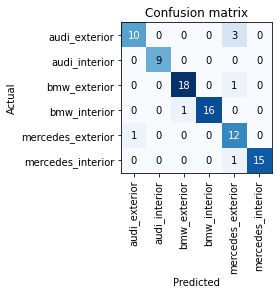

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Inference
Now, to really test our model, we will *test* it using images that he has not seen before, or else it would be conidered cheating. It's like a student passing an exam he will not be given questions that he already knows the answers to but rather will probably get questions that he had not seen before, but in the context of what he studied. 

> When using a model to get predictions, we call it **Inference**.

For that we'll be using the *predict* method, that just takes the image as the input. And returns three things, the prediction (what car it thinks it is), the "posistion" of the label in the *vocab*, and the probability for each label. 

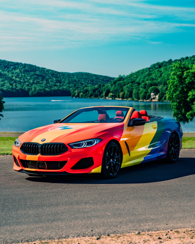

In [13]:
img = PILImage.create('/content/bmw_exterior_2.jpg')
img.to_thumb(244)

In [14]:
predict, position, proba = learn.predict(img)
predict, position, proba

('bmw_exterior',
 tensor(2),
 tensor([9.8757e-08, 2.9618e-10, 1.0000e+00, 1.8380e-09, 4.8084e-06, 4.3692e-08]))

Our model thinks it's a BMW exterior with 100% certainty, PERFECT !!!  

To export our model for later use, or integrate in an app, or whatever have you, we just use the *export* method.  
Which will export the model as a *pickle* file, with all the learned weights and how it should load the data (so you just import, plug in the image and you get the results).

> We use *load_learner* to load the model.

In [ ]:
learn.export()